In [1]:
import os
import pickle
import time
import sys
#sys.path.insert(0, '/home/farnoush/symbolicXAI/')
import numpy as np
import torch

# Model
from symb_xai.lrp.symbolic_xai import ViTSymbolicXAI
from symb_xai.model.vision_transformer import ModifiedViTForImageClassification

# Dataset
from symb_xai.dataset.part_imagenet import PartImageNetDataset
import matplotlib.pylab as plt
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
import transformers
import torchvision
import requests
from PIL import Image
from io import BytesIO
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image, scale_cam_image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection
import cv2

## Load model

Load the ViT-Base model trained on the ImageNet dataset.

In [2]:
processor = transformers.AutoImageProcessor.from_pretrained("WinKawaks/vit-tiny-patch16-224")
model = transformers.AutoModelForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224")

model.eval()

model.vit.embeddings.patch_embeddings.requires_grad = False
model.vit.embeddings.patch_embeddings.requires_grad = False

for name, param in model.named_parameters():
    if name.endswith('embed'):
        param.requires_grad = False

pretrained_embeddings = model.vit.embeddings

## Load dataset

import json
import numpy as np
import os
import shutil

with open('/home/space/datasets/PartImageNet_OOD/train.json', 'r') as fopen:
    a = json.load(fopen)

q = []
for i in os.listdir('/home/space/datasets/PartImageNet_OOD/train'):
    q.append(i)

map = {j: i for (i, j) in enumerate(q)}

if not os.path.exists('/home/space/datasets/PartImageNet_OOD/train_train/'):
    os.mkdir('/home/space/datasets/PartImageNet_OOD/train_train/')
    os.mkdir('/home/space/datasets/PartImageNet_OOD/train_test/')

with open('./newdset.txt', 'w') as fopen:
    for i in a['images']:
        id = i['id']
        test = 1 if np.random.rand() < 0.1 else 0
        folder = i['file_name'].split('_')[0]
        filename = i['file_name']
        label = map[folder]
        fopen.write(f'{id}\t{test}\t{label}\t{folder}\t{filename}\n')
        if test:
            if not os.path.exists(f'/home/space/datasets/PartImageNet_OOD//train_test/{folder}'):
                os.mkdir(f'/home/space/datasets/PartImageNet_OOD//train_test/{folder}')
            shutil.copy(f'/home/space/datasets/PartImageNet_OOD//train/{folder}/{filename}', f'/home/space/datasets/PartImageNet_OOD//train_test/{folder}/')
        else:
            if not os.path.exists(f'/home/space/datasets/PartImageNet_OOD//train_train/{folder}'):
                os.mkdir(f'/home/space/datasets/PartImageNet_OOD//train_train/{folder}')
            shutil.copy(f'/home/space/datasets/PartImageNet_OOD//train/{folder}/{filename}', f'/home/space/datasets/PartImageNet_OOD//train_train/{folder}/')

In [4]:
import os
import pandas as pd
import skimage.draw
import torch.utils.data
import numpy as np
import torch.utils.data
from pycocotools.coco import COCO
import pickle
import torchvision.transforms.v2 as transforms
import torchvision.io
from PIL import Image


car_synset_dict = {
    "convertible": "n02930766",
    "sports car": "n04285008",
    "minivan": "n03770679",
    "jeep": "n03594945",
    "limousine": "n03670208",
    "race car": "n04037443",
    "cab": "n02965783",
    "police car": "n04252225",
    "ambulance": "n02701002",
    "fire engine": "n03345487"
}


bike_synset_dict = {
    "bicycle": "n03792782",
    "mountain bike": "n03785016",
    "motorcycle": "n03790512",
    "moped": "n03791053",
    "dirt bike": "n03790512",
    "road bike": "n03773504",
    "racing bike": "n03792782",
    "cruiser": "n03792782"
}



class PartImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, data_path: str, mode: str = 'train', get_masks: bool = False, image_size: int = 224,
                 evaluate: bool = False):
        """
        PartImageNet dataset
        Parameters
        ----------
        data_path: str
            Directory containing the 'train_train', 'train_test', and 'test' folders
        mode: str
            Whether to use the training or validation split
        get_masks: bool
            Whether to return the ground truth masks
        image_size: int
            Size of the images
        evaluate: bool
            Set to true to evaluate parts (disables transforms such as normalization, crop, etc.)
        """
        self.mode = mode
        self.data_path = data_path
        self.get_masks = get_masks
        dataset = pd.read_csv(data_path + "/" + "newdset.txt", sep='\t', names=["index", "test", "label", "class", "filename"])
        if mode == "train":
            self.dataset = dataset.loc[dataset['test'] == 0]
            self.transform = self.get_transforms(image_size, evaluate)[0]
        elif mode == "val":
            self.dataset = dataset.loc[dataset['test'] == 1]
            self.transform = self.get_transforms(image_size, evaluate)[1]
        elif mode == "test":
            self.dataset = dataset.loc[dataset['test'] == 1]
            self.transform = self.get_transforms(image_size, evaluate)[1]
        annFile = os.path.join(data_path, f"train.json")

        coco = COCO(annFile)
        self.coco = coco

    def getmasks(self, i):
        idx = self.dataset.loc[i]['index']
        idx = int(idx)
        coco = self.coco
        img = coco.loadImgs(idx)[0]
        annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
        anns = coco.loadAnns(annIds)
        cat_ids = [ann['category_id'] for ann in anns]
        polygons = []
        for ann in anns:
            for seg in ann['segmentation']:
                poly = np.array(seg).reshape((int(len(seg) / 2), 2))
                polygons.append(poly)
        for cat, p in zip(cat_ids, polygons):
            mask = skimage.draw.polygon2mask((img['width'], img['height']), p)
            try:
                mask_tensor[cat] += torch.FloatTensor(mask)
            except NameError:
                mask_tensor = torch.zeros(size=(40, mask.shape[-2], mask.shape[-1]))
                mask_tensor[cat] += torch.FloatTensor(mask)
        try:
            mask_tensor = torch.where(mask_tensor > 0.1, 1, 0).permute(0, 2, 1)
            return mask_tensor
        except UnboundLocalError:
            # if an image has no ground truth parts
            return None

    def __len__(self):
        return len(self.dataset['index'])

    def __getitem__(self, idx):
        curr_row = self.dataset.loc[idx]
        folder = curr_row['class']
        imgname = curr_row['filename']
        
        if self.mode == 'train':
            path = f"{self.data_path}/train_train/{folder}/{imgname}"
            print(path)
        elif self.mode == 'test':
            path = f"{self.data_path}/train_test/{folder}/{imgname}"

        im = torchvision.io.read_image(path, torchvision.io.ImageReadMode.RGB)
        label = curr_row['label']
        im = self.transform(im)

        if not self.get_masks:
            return im, label

        mask = self.getmasks(idx)
        if mask == None:
            mask = torch.zeros(size=(40, im.shape[-2], im.shape[-1]))
        mask = transforms.Resize(size=(im.shape[-2], im.shape[-1]),
                interpolation=transforms.InterpolationMode.NEAREST)(mask)
        return im, label, mask

    @staticmethod
    def get_transforms(image_size: int, evaluate: bool = False):
        if not evaluate:
            train_transforms = transforms.Compose([
                transforms.Resize(size=image_size, antialias=True),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(0.1),
                transforms.RandomAffine(degrees=90, translate=(0.2, 0.2), scale=(0.8, 1.2)),
                transforms.RandomCrop(image_size),
                transforms.ToDtype(torch.float32, scale=True)
            ])
            test_transforms = transforms.Compose([
                transforms.Resize(size=image_size, antialias=True),
                transforms.CenterCrop(size=image_size),
                transforms.ToDtype(torch.float32, scale=True)
            ])
        else:
            train_transforms = transforms.Compose([
                transforms.Resize(size=image_size, antialias=True),
                transforms.ToDtype(torch.float32, scale=True)
            ])
            test_transforms = transforms.Compose([
                transforms.Resize(size=image_size, antialias=True),
                transforms.ToDtype(torch.float32, scale=True)
            ])
        return train_transforms, test_transforms

In [5]:
val_set = PartImageNetDataset(data_path="/home/space/datasets/PartImageNet_OOD/", mode='test', get_masks=True, image_size=(224, 224),
                 evaluate=True)
val_loader = DataLoader(val_set, shuffle=False)

loading annotations into memory...
Done (t=1.77s)
creating index...
index created!


In [6]:
car_images = val_set.dataset[val_set.dataset['class'].isin(car_synset_dict.values())]['index']
bike_images = val_set.dataset[val_set.dataset['class'].isin(bike_synset_dict.values())]['index']

In [7]:
val_set.dataset[val_set.dataset['class'].isin(bike_synset_dict.values())]

,index,test,label,class,filename
16217,16217,1,93,n03792782,n03792782_25799.JPEG
16224,16224,1,93,n03792782,n03792782_1982.JPEG
16279,16279,1,93,n03792782,n03792782_13735.JPEG
16309,16309,1,14,n03791053,n03791053_6544.JPEG
16318,16318,1,93,n03792782,n03792782_7638.JPEG
16321,16321,1,93,n03792782,n03792782_3883.JPEG
16366,16366,1,93,n03792782,n03792782_10734.JPEG
16381,16381,1,14,n03791053,n03791053_12573.JPEG
16415,16415,1,14,n03791053,n03791053_15947.JPEG
16443,16443,1,93,n03792782,n03792782_3181.JPEG


In [8]:
inputs, _, landmarks = val_set.__getitem__(16224)

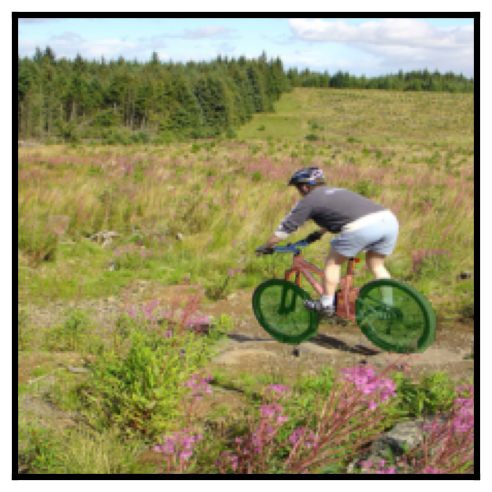

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming inputs and landmarks are already loaded as tensors
# inputs: torch.Tensor of shape [C, H, W] for RGB image
# landmarks: torch.Tensor of shape [40, H, W] for binary masks

# Convert inputs to numpy for plotting (assuming C is 3 for RGB)
image = inputs.permute(1, 2, 0).numpy()  # [H, W, 3]

# Initialize a canvas to store the combined mask overlay (RGBA)
height, width = landmarks.shape[1], landmarks.shape[2]
combined_mask = np.zeros((height, width, 4), dtype=np.uint8)  # RGBA

# Define a list of 40 unique colors for each mask (RGBA format)
unique_colors = [
    (255, 0, 0, 100),    # Red
    (0, 255, 0, 100),    # Green
    (0, 0, 255, 100),    # Blue
    (255, 255, 0, 100),  # Yellow
    (255, 0, 255, 100),  # Magenta
    (0, 255, 255, 100),  # Cyan
    (192, 192, 192, 100), # Silver
    (128, 0, 0, 100),    # Maroon
    (128, 128, 0, 100),  # Olive
    (0, 128, 0, 100),    # Dark Green
    (0, 0, 128, 100),    # Navy
    (128, 0, 128, 100),  # Purple
    (0, 128, 128, 100),  # Teal
    (255, 165, 0, 100),  # Orange
    (255, 20, 147, 100), # Deep Pink
    (75, 0, 130, 100),   # Indigo
    (255, 69, 0, 100),   # Red-Orange
    (173, 216, 230, 100), # Light Blue
    (144, 238, 144, 100), # Light Green
    (255, 228, 196, 100), # Bisque
    (240, 128, 128, 100), # Light Coral
    (128, 128, 128, 100), # Gray
    (128, 255, 0, 100),   # Lime
    (0, 255, 128, 100),   # Spring Green
    (255, 128, 0, 100),   # Orange Red
    (0, 128, 255, 100),   # Sky Blue
    (128, 0, 255, 100),   # Violet
    (255, 99, 71, 100),   # Tomato
    (100, 149, 237, 100), # Cornflower Blue
    (255, 228, 0, 100),   # Bright Yellow
    (0, 100, 0, 100),     # Dark Green
    (238, 130, 238, 100), # Violet
    (255, 160, 122, 100), # Light Salmon
    (219, 112, 147, 100), # Pale Violet Red
    (0, 191, 255, 100),   # Deep Sky Blue
    (85, 107, 47, 100),   # Dark Olive Green
    (240, 255, 240, 100), # Honeydew
    (255, 245, 238, 100), # Seashell
    (240, 248, 255, 100), # Alice Blue
    (255, 215, 0, 100),   # Gold
    (255, 192, 203, 100)  # Pink
]

# Ensure the number of unique colors matches the number of masks
if len(unique_colors) < landmarks.shape[0]:
    raise ValueError(f"Not enough unique colors defined. Need at least {landmarks.shape[0]} colors.")

# Loop through each binary mask in landmarks
for idx in range(landmarks.shape[0]):
    mask = landmarks[idx].numpy()  # Convert tensor to numpy array
    if mask.sum() > 0:  # Check if the mask is non-zero
        rgba_color = unique_colors[idx]  # Use predefined unique color

        # Apply color to the combined mask where the current mask is 1
        combined_mask[mask == 1] = rgba_color  # Color where mask is 1

# Plot the result
fig, axs = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
plt.setp(axs.spines.values(), lw=3)
plt.imshow(image)  # Show the original image
plt.imshow(combined_mask)  # Overlay the combined mask
plt.xticks([])
plt.yticks([])
plt.show()

## Use SymbolicXAI

In [10]:
inputs.shape

torch.Size([3, 224, 224])

tensor(671)


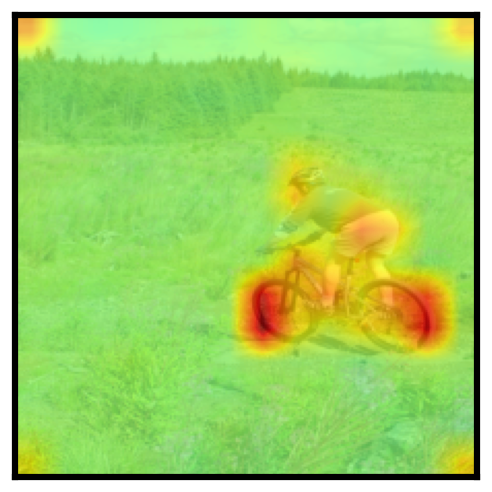

In [11]:
from copy import deepcopy

logits = model(inputs.unsqueeze(0)).logits
labels = logits.argmax()
# labels = 671
print(labels)
targets = torch.eye(1000, dtype=inputs.dtype)[labels]

symb_xai_vit = ViTSymbolicXAI(
        model=deepcopy(model),
        embeddings=pretrained_embeddings,
        sample=inputs.unsqueeze(0),
        target=targets,
        scal_val=1.,
        use_lrp_layers=True
    )

R = symb_xai_vit.node_relevance().detach().numpy()[1:] 

R = R / np.max(np.abs(R))  # Normalize between [-1, 1]# normalize to [-1,1] wrt to max relevance magnitude
fig, axs = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
plt.setp(axs.spines.values(), lw=3)
plt.imshow(cv2.resize(R.reshape(14, 14), (224, 224)), vmin=-1, vmax=1, cmap='jet')
plt.imshow(inputs.permute(1, 2, 0), alpha=0.3)
plt.xticks([])
plt.yticks([])
plt.show()

In [33]:
!pip3 install pydantic

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 KB 5.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.1 MB/s eta 0:00:00a 0:00:01


In [1]:
from symb_xai.query_search.utils import comp_all_harsanyi_sst
# hars_div = comp_all_harsanyi_sst(symb_xai_vit, harsanyi_maxorder=2, neg_tokens=None)

## Utils

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_masked_patch_ids(image, mask, patch_size):
    """
    Returns unique IDs of patches that include parts of the segmentation mask.

    Args:
        image (np.array): Original image array.
        mask (np.array): Binary mask array with the same height and width as the image.
        patch_size (tuple): Size of each patch (height, width).
    
    Returns:
        List[int]: List of unique integer IDs for patches that contain the mask.
    """
    # Get image dimensions
    img_height, img_width = image.shape[:2]
    patch_height, patch_width = patch_size
    
    # Calculate the total number of patches along each dimension
    num_patches_y = (img_height + patch_height - 1) // patch_height
    num_patches_x = (img_width + patch_width - 1) // patch_width
    
    # Initialize list to store patch IDs containing the mask
    masked_patch_ids = []
    
    # Loop over the image in steps of the patch size
    for i in range(0, img_height, patch_height):
        for j in range(0, img_width, patch_width):
            # Calculate the current patch ID
            patch_id = (i // patch_height) * num_patches_x + (j // patch_width)
            
            # Extract the current patch from the mask
            mask_patch = mask[i:i + patch_height, j:j + patch_width]
            
            # Check if there are any mask pixels in this patch
            if np.any(mask_patch):
                # Store the patch ID
                masked_patch_ids.append(patch_id)
    
    return masked_patch_ids


def color_masked_patches(image, masks, patch_size):
    """
    Colors the patches containing each mask on a copy of the original image.

    Args:
        image (np.array): Original image array.
        masks (List[np.array]): List of binary mask arrays, one per mask.
        patch_size (tuple): Size of each patch (height, width).
    
    Returns:
        np.array: Image with colored rectangles for each mask.
    """
    # Create a color map for each mask
    colors = plt.cm.get_cmap("jet", len(masks))
    
    # Plot the original image
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    img_height, img_width = image.shape[:2]
    patch_height, patch_width = patch_size

    for mask_idx, mask in enumerate(masks):
        color = colors(mask_idx)[:3]  # Get the color for the current mask
        masked_patch_ids = get_masked_patch_ids(image, mask, patch_size)
        
        for patch_id in masked_patch_ids:
            # Calculate row and column from patch_id
            row = (patch_id * patch_height) // img_width
            col = (patch_id % (img_width // patch_width)) * patch_width
            
            # Draw a rectangle at the patch location
            rect = patches.Rectangle(
                (col, row * patch_height), patch_width, patch_height, linewidth=1,
                edgecolor=color, facecolor=color, alpha=0.4
            )
            ax.add_patch(rect)
    
    plt.axis("off")
    plt.show()

In [99]:
masks = []
patches_ids = []
for idx in range(landmarks.shape[0]):
    if landmarks[idx].sum() > 0:
        patch_ids = get_masked_patch_ids(image, landmarks[idx].numpy().astype(np.uint8), (16, 16))
        patches_ids.append(patch_ids)
        masks.append(landmarks[idx].numpy().astype(np.uint8))

/tmp/ipykernel_3007498/2462137562.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("jet", len(masks))


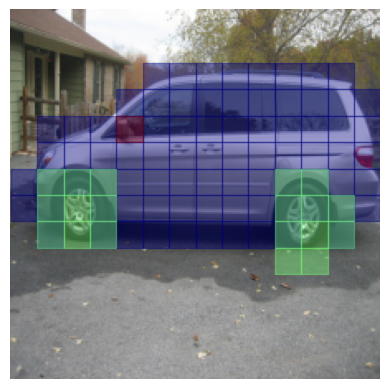

In [100]:
color_masked_patches(image, masks, (16, 16))

## Symbolic XAI

In [101]:
body = patches_ids[0]
tier = patches_ids[1]
side_mirror = patches_ids[2]

body_complement = list(set(symb_xai_vit.node_domain) - set(body))
tier_complement = list(set(symb_xai_vit.node_domain) - set(tier))
side_mirror_complement = list(set(symb_xai_vit.node_domain) - set(side_mirror))

tier_relevance = symb_xai_vit.subgraph_relevance(tier)
side_mirror_relevance = symb_xai_vit.subgraph_relevance(side_mirror)
# tier_relevance = symb_xai_vit.symb_or(tier) + symb_xai_vit.symb_or(side_mirror_complement) - symb_xai_vit.symb_or(tier + side_mirror_complement)
# side_mirror_relevance = symb_xai_vit.symb_or(side_mirror) + symb_xai_vit.symb_or(tier_complement) - symb_xai_vit.symb_or(side_mirror + tier_complement)
tier_and_mirror_relevance = symb_xai_vit.symb_or(tier) + symb_xai_vit.symb_or(side_mirror) - symb_xai_vit.symb_or(tier + side_mirror)

R_values = [tier_relevance.item(), side_mirror_relevance.item(), tier_and_mirror_relevance]

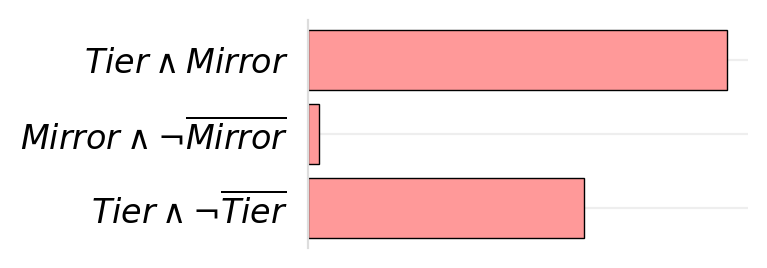

In [102]:
import matplotlib

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'hatch.linewidth': 0.5})
cmap_neg = matplotlib.colormaps.get_cmap('Blues')
cmap_pos = matplotlib.colormaps.get_cmap('Reds')

red_color = (1,0.6,0.6)
blue_color = (.6,.6,1)

width=0.7
alpha = 1
# labels = ['$Eyes \\wedge \\neg{Mouth}$', '$\\neg{Eyes} \wedge Mouth$', '$Eyes \\wedge Mouth$']
labels = ['$Tier \\wedge \\neg{\\overline{Tier}}$', '$Mirror \\wedge \\neg{\\overline{Mirror}}$', '$Tier \\wedge Mirror$']
fig, ax = plt.subplots(1, figsize=(4, 1.5), dpi=200)
for i, value in enumerate(R_values):
    if i == 0:
        label = 'Tier'
    elif i == 1:
        label = 'Side Mirror'
    elif i == 2:
        label = 'Tier & Side Mirror'
            
    if value < 0:
        if label:
            bars = ax.barh(i, value, alpha=alpha, edgecolor='black',
                          color=blue_color, linewidth=0.5, label=label)
        else:
            bars = ax.barh(i, value, alpha=alpha, edgecolor='black',
                          color=blue_color, linewidth=0.5)
    else:
        if label:
            bars = ax.barh(i, value, alpha=alpha, edgecolor='black',
                          color=red_color, linewidth=0.5, label=label)
        else:
            bars = ax.barh(i, value, alpha=alpha, edgecolor='black',
                          color=red_color, linewidth=0.5)


ax.set_yticks(np.arange(len(R_values)), labels, rotation=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_facecolor("white")

if False:
    legend = ax.legend(title='Context', title_fontsize=12, fontsize=12, loc="upper center",
                       bbox_to_anchor=(-.1, .9))
    title = legend.get_title()
    title.set_weight('bold')

fig.show()
plt.tight_layout()

In [90]:
R_values

[0.038396988064050674, 0.0009247114649042487, tensor(-0.0006)]